# Different data formats

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import pathlib

import numpy as np
import pandas as pd
from rich import print

import cellpy
from cellpy.utils import example_data, plotutils

In [9]:
# Comment out this when running the notebook locally to get interactive plots
import plotly.io as pio
pio.renderers.default = "png"

In [10]:
def head(f, n=5):
    print(f" {f.name} ".center(80, "-"))
    with open(f) as datafile:
        for j in range(n):
            line = datafile.readline()
            print(f"[{j+1:02}] {line.strip()}")
        

## PEC CSV data

In [11]:
p = example_data.pec_file_path()
print(f"{p.name=}")

p.name='pec.csv'

In [12]:
head(p, 35)

----------------------------------- pec.csv ------------------------------------

[01] Request Year:,2019

[02] Test:,187

[03] Test Description:,

[04] TestRegime Name:,FirstCell dQdV C/25

[05] TestRegime Suffix:,HWL

[06] TestRegime CellSize:,Default cellsize

[07] TestRegime Version:,1

[08] Project Group Name:,Immediate

[09] Project Group Description:,Immediate

[10] Project Group Memo:,

[11] Project Group Storage Environment:,R.T./AMB

[12] Project Group Test Environment:,R.T./AMB

[13] Number Of Cells:,1

[14] Parameter names:,

[15] Parameter values:,

[16] Variable names:

[17] LotID:,

[18] Lot Description:,

[19] Date Made:,1/21/2003 0:00

[20] Origin:,Other

[21] Requestor:,Admin

[22] Product ID:,Default product

[23] Storage Temp:,R.T./AMB

[24] Storage Delay:,0 days

[25] Test Temp:,R.T./AMB

[26] Start Time:,02/22/2019 16:21:35

[27] End Time:,1/1/0001 0:00

[28] Operator Instructions:,Also connect cell temp to channel TC-K and ambient temp to NTC

[29] #RESULTS CHECK

[30] ReqYear,Test,CellNr,Type,Value,Reason,

[31] 2019,187,1,1,3272,3,

[32] #END RESULTS CHECK

[33] Test,Cell,Rack,Shelf,Position,Cell ID,Step,Cycle,Total Time (Seconds),Load On Time (Seconds),Step Time 
(Seconds),Cycle Charge Time (Seconds),Cycle Discharge Time (Seconds),Real Time,Position Start Time,Voltage 
(mV),Current (mA),Charge Capacity (mAh),Discharge Capacity (mAh),Charge Capacity (mWh),Discharge Capacity 
(mWh),ReasonCode,50% DoD (mV),PeakPower 1 (W),PeakPower 2 (W),Open Circuit Voltage 1 (V),Open Circuit Voltage 2 
(V),Internal Resistance 1 (mOhm),Internal Resistance 2 (mOhm),Ambient temperature (Â°C),Cell surface temperature 
(Â°C),DC Internal Resistance (mOhm),AC Internal Resistance (mOhm),Station Temperature (Â°C),

[34] 187,1,SBT0550,001,1,,0,0,1,0,1,0,0,02/22/2019 16:23:27,02/22/2019 
16:23:26,3272.632,0,0,0,0,0,30,0,0,0,0,0,0,0,25.83,24.9,,,,

[35] 187,1,SBT0550,001,1,,0,0,5,0,5,0,0,02/22/2019 16:23:31,02/22/2019 
16:23:26,3272.2776,0,0,0,0,0,30,0,0,0,0,0,0,0,25.83,24.9,,,,

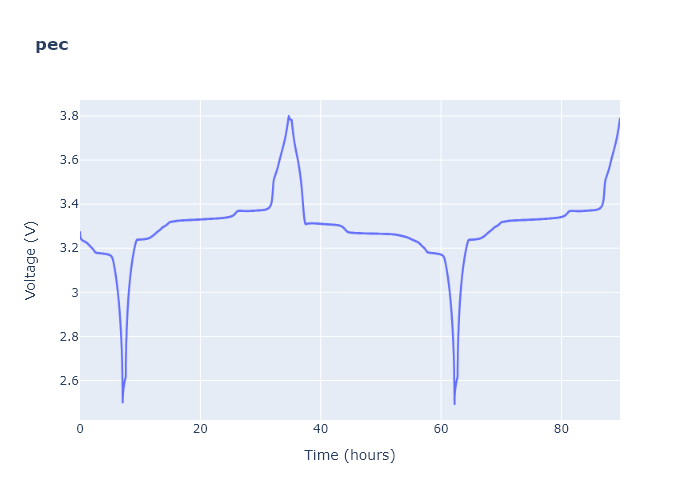

In [13]:
c = cellpy.get(p, instrument="pec_csv", cycle_mode="full_cell")
plotutils.raw_plot(c)

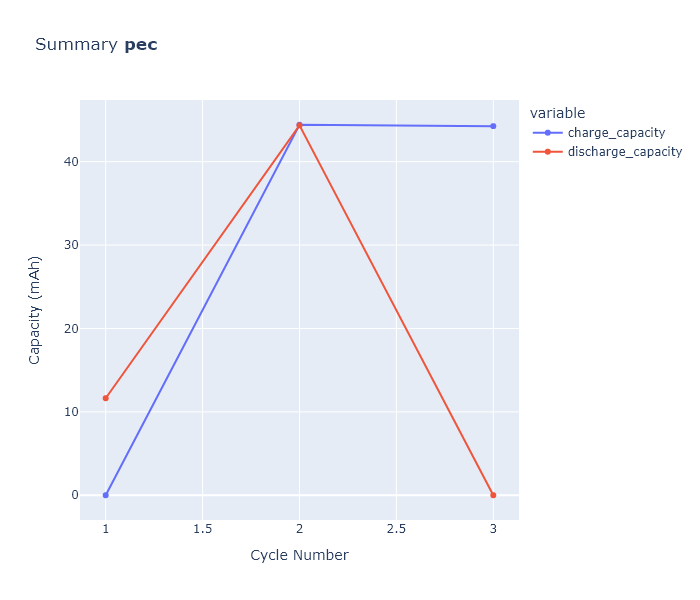

In [14]:
plotutils.summary_plot(c, y="capacities")

## MACCOR

In [28]:
p = example_data.maccor_file_path()
print(f"{p.name=}")

  0%|          | 0.00/115k [00:00<?, ?B/s]

p.name='maccor_three.txt'

In [29]:
head(p, 20)

------------------------------- maccor_three.txt -------------------------------

[01] Today''s Date      03/28/2022 12:50:27 PM

[02]

[03] Date of Test:      08/23/2021 6:04:18 PM

[04]

[05] Rec#       Cyc#    Step    TestTime        StepTime        mAmp-hr mWatt-hr        mAmps   Volts   State   ES 
DPt Time        Unnamed: 12

[06] 1  0       1         0d 00:00:00.00          0d 00:00:00.00        0.0     0.0     0.0     1853.8186       R  
0       08/23/2021 6:04:18 PM

[07] 2  0       1         0d 00:01:00.00          0d 00:01:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:05:18 PM

[08] 3  0       1         0d 00:02:00.00          0d 00:02:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:06:18 PM

[09] 4  0       1         0d 00:03:00.00          0d 00:03:00.00        0.0     0.0     0.0     1853.2082       R  
1       08/23/2021 6:07:18 PM

[10] 5  0       1         0d 00:04:00.00          0d 00:04:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:08:18 PM

[11] 6  0       1         0d 00:05:00.00          0d 00:05:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:09:18 PM

[12] 7  0       1         0d 00:06:00.00          0d 00:06:00.00        0.0     0.0     0.0     1853.2082       R  
1       08/23/2021 6:10:18 PM

[13] 8  0       1         0d 00:07:00.00          0d 00:07:00.00        0.0     0.0     0.0     1853.2082       R  
1       08/23/2021 6:11:18 PM

[14] 9  0       1         0d 00:08:00.00          0d 00:08:00.00        0.0     0.0     0.0     1852.903        R  
1       08/23/2021 6:12:18 PM

[15] 10 0       1         0d 00:09:00.00          0d 00:09:00.00        0.0     0.0     0.0     1853.2082       R  
1       08/23/2021 6:13:18 PM

[16] 11 0       1         0d 00:10:00.00          0d 00:10:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:14:18 PM

[17] 12 0       1         0d 00:11:00.00          0d 00:11:00.00        0.0     0.0     0.0     1853.2082       R  
1       08/23/2021 6:15:18 PM

[18] 13 0       1         0d 00:12:00.00          0d 00:12:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:16:18 PM

[19] 14 0       1         0d 00:13:00.00          0d 00:13:00.00        0.0     0.0     0.0     1853.2082       R  
1       08/23/2021 6:17:18 PM

[20] 15 0       1         0d 00:14:00.00          0d 00:14:00.00        0.0     0.0     0.0     1853.3608       R  
1       08/23/2021 6:18:18 PM

### Different models

The data from 'maccor' can be exported in many formats. Some of them are supported by `cellpy`. If not, take a look at how to make custom loaders.
Let's see what is available at the moment.

In [30]:
from cellpy.readers import core

In [31]:
# Check which loaders are available for maccor:
config = core.instrument_configurations("maccor")
config.keys()

dict_keys(['maccor_txt'])

In [32]:
# Check which models are available for maccor:
config["maccor_txt"]["__all__"]

['default',
 'ZERO',
 'ONE',
 'TWO',
 'THREE',
 'S4000-UBHAM',
 'S4000-KIT',
 'S4000-WMG']

In [34]:
config["maccor_txt"]["THREE"]

{'config_params': ModelParameters(name='THREE', file_info={'raw_extension': 'txt'}, unit_labels={'resistance': 'Ohms', 'time': 's', 'current': 'A', 'voltage': 'V', 'power': 'W', 'capacity': 'Ah', 'energy': 'Wh', 'temperature': 'C'}, incremental_unit_labels={}, normal_headers_renaming_dict={'data_point_txt': 'Rec#', 'cycle_index_txt': 'Cyc#', 'step_index_txt': 'Step', 'test_time_txt': 'TestTime', 'step_time_txt': 'StepTime', 'charge_capacity_txt': 'mAmp-hr', 'charge_energy_txt': 'mWatt-hr', 'current_txt': 'mAmps', 'voltage_txt': 'Volts', 'datetime_txt': 'DPt Time'}, not_implemented_in_cellpy_yet_renaming_dict={}, columns_to_keep=[], states={'column_name': 'State', 'charge_keys': ['C'], 'discharge_keys': ['D'], 'rest_keys': ['R']}, raw_units={'current': 'A', 'charge': 'Ah', 'mass': 'g', 'voltage': 'V'}, raw_limits={'current_hard': 1e-13, 'current_soft': 1e-05, 'stable_current_hard': 2.0, 'stable_current_soft': 4.0, 'stable_voltage_hard': 2.0, 'stable_voltage_soft': 4.0, 'stable_charge_ha

In [36]:
config["maccor_txt"]["THREE"]["config_params"].formatters

{'skiprows': 2,
 'sep': '\t',
 'header': 0,
 'encoding': 'ISO-8859-1',
 'decimal': ',',
 'thousands': None}

(cellpy) - running pre-processor: remove_empty_lines
(cellpy) - self.sep='\t', self.skiprows=2, self.header=0, self.encoding='ISO-8859-1', self.decimal=','
(cellpy) - running post-processor: rename_headers
(cellpy) - running post-processor: remove_last_if_bad
(cellpy) - running post-processor: split_capacity
(cellpy) - running post-processor: split_current
(cellpy) - running post-processor: set_index
(cellpy) - running post-processor: set_cycle_number_not_zero
(cellpy) - running post-processor: convert_date_time_to_datetime
(cellpy) - running post-processor: convert_step_time_to_timedelta
(cellpy) - running post-processor: convert_test_time_to_timedelta


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

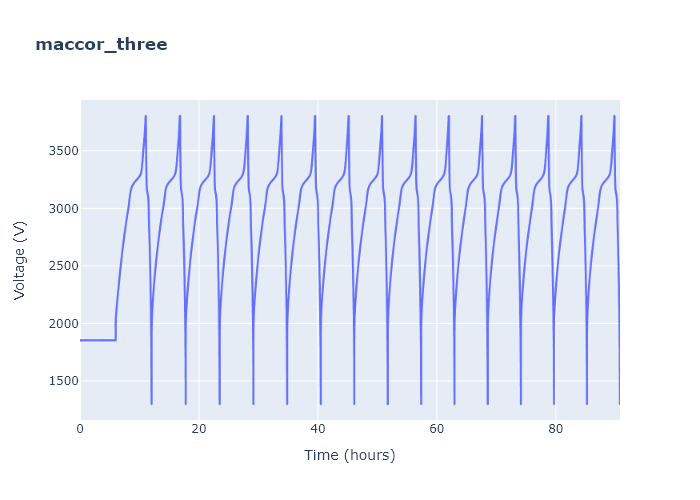

In [37]:
c = cellpy.get(p, instrument="maccor_txt", model="THREE", cycle_mode="full_cell")
print(c.get_cycle_numbers())
plotutils.raw_plot(c)

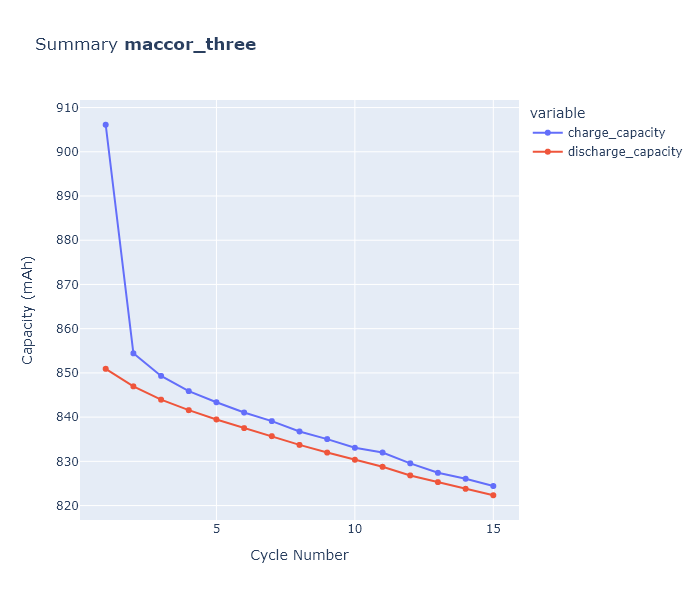

In [38]:
plotutils.summary_plot(c, y="capacities")

## NEWARE

## Custom data